# LSTM/RNN Model for Fake News Classification

This notebook implements Long Short-Term Memory (LSTM) and other RNN architectures for fake news classification.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import SpatialDropout1D, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# QUICK SETUP CELL - Load data from previous notebooks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Add paths for imports
sys.path.append('../src')
sys.path.append('.')

print("🔧 SETTING UP NOTEBOOK 4 (LSTM)...")

# Try to load data from previous notebooks
try:
    # Load CNN results from notebook 3
    if os.path.exists('../data/persistence/notebook3_cnn_results.pkl'):
        with open('../data/persistence/notebook3_cnn_results.pkl', 'rb') as f:
            cnn_data = pickle.load(f)
        
        print("✅ Loaded CNN results from Notebook 3")
        print(f"   - CNN accuracies available: {list(cnn_data.keys())}")
        
        # Extract useful data
        tokenizer = cnn_data.get('tokenizer')
        config = cnn_data.get('config', {})
        
        if tokenizer:
            print("✅ Using CNN tokenizer for consistency")
        
    else:
        print("⚠️ No CNN results found, will create new tokenizer")
        cnn_data = None
        
except Exception as e:
    print(f"⚠️ Error loading CNN data: {e}")
    cnn_data = None

# Try to load preprocessed dataset
try:
    if os.path.exists('../data/persistence/notebook2_processed_df.csv'):
        df = pd.read_csv('../data/persistence/notebook2_processed_df.csv')
        print(f"✅ Loaded processed dataset: {df.shape}")
    else:
        df = pd.read_csv('../data/combined_news_dataset.csv')
        print(f"✅ Loaded raw dataset: {df.shape}")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

print("🚀 NOTEBOOK 4 ENVIRONMENT READY!")
print(f"📊 Dataset: {df.shape if 'df' in locals() else 'Not loaded'}")
print(f"⚙️ CNN tokenizer: {'✅ Available' if 'tokenizer' in locals() and tokenizer else '❌ Not available'}")
print("\n🔗 Starting LSTM model implementation...")

🔧 SETTING UP NOTEBOOK 4 (LSTM)...
✅ Loaded CNN results from Notebook 3
   - CNN accuracies available: ['standard_cnn_accuracy', 'multi_cnn_accuracy', 'standard_cnn_loss', 'multi_cnn_loss', 'best_model_name', 'tokenizer', 'config', 'X_train_sequences', 'X_test_sequences', 'y_train_labels', 'y_test_labels', 'comparison_df']
✅ Using CNN tokenizer for consistency
✅ Loaded processed dataset: (44889, 10)
🚀 NOTEBOOK 4 ENVIRONMENT READY!
📊 Dataset: (44889, 10)
⚙️ CNN tokenizer: ✅ Available

🔗 Starting LSTM model implementation...


# Use tokenizer and config from CNN notebook if available, otherwise create new
if 'cnn_data' in locals() and cnn_data and 'tokenizer' in cnn_data:
    tokenizer = cnn_data['tokenizer']
    config = cnn_data['config']
    
    MAX_VOCAB_SIZE = config.get('max_vocab_size', 20000)
    MAX_SEQUENCE_LENGTH = config.get('max_sequence_length', 500)
    EMBEDDING_DIM = config.get('embedding_dim', 100)
    
    print("✅ Using tokenizer and config from CNN notebook")
    print(f"Vocabulary size: {MAX_VOCAB_SIZE}")
    print(f"Max sequence length: {MAX_SEQUENCE_LENGTH}")
    print(f"Embedding dimension: {EMBEDDING_DIM}")
    
else:
    print("⚠️ Creating new tokenizer...")
    
    # Configuration
    MAX_VOCAB_SIZE = 20000
    MAX_SEQUENCE_LENGTH = 500
    EMBEDDING_DIM = 100
    
    # Light preprocessing function
    import re
    def light_preprocess(text):
        if pd.isna(text):
            return ''
        text = text.lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'\S+@\S+', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = ' '.join(text.split())
        return text
    
    # Prepare text
    df['cnn_text'] = (df['title'] + ' ' + df['text']).apply(light_preprocess)
    df = df[df['cnn_text'] != ''].reset_index(drop=True)
    
    # Create tokenizer
    from tensorflow.keras.preprocessing.text import Tokenizer
    tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
    tokenizer.fit_on_texts(df['cnn_text'].values)
    
    print(f"✅ Created new tokenizer")
    print(f"Vocabulary size: {MAX_VOCAB_SIZE}")
    print(f"Max sequence length: {MAX_SEQUENCE_LENGTH}")
    print(f"Embedding dimension: {EMBEDDING_DIM}")

print(f"\nDataset shape: {df.shape}")

In [3]:
# Load the dataset
df = pd.read_csv('../data/combined_news_dataset.csv')
print(f"Dataset shape: {df.shape}")

# Load the tokenizer from CNN notebook (or create if not available)
try:
    with open('../models/cnn_tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
    
    with open('../models/cnn_config.pickle', 'rb') as handle:
        config = pickle.load(handle)
    
    MAX_VOCAB_SIZE = config['max_vocab_size']
    MAX_SEQUENCE_LENGTH = config['max_sequence_length']
    EMBEDDING_DIM = config['embedding_dim']
    
    print("Loaded existing tokenizer and configuration")
    
except FileNotFoundError:
    print("Creating new tokenizer...")
    
    # Configuration
    MAX_VOCAB_SIZE = 20000
    MAX_SEQUENCE_LENGTH = 500
    EMBEDDING_DIM = 100
    
    # Light preprocessing function
    import re
    def light_preprocess(text):
        if pd.isna(text):
            return ''
        text = text.lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'\S+@\S+', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = ' '.join(text.split())
        return text
    
    # Prepare text
    df['cnn_text'] = (df['title'] + ' ' + df['text']).apply(light_preprocess)
    df = df[df['cnn_text'] != ''].reset_index(drop=True)
    
    # Create tokenizer
    tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
    tokenizer.fit_on_texts(df['cnn_text'].values)

print(f"Vocabulary size: {MAX_VOCAB_SIZE}")
print(f"Max sequence length: {MAX_SEQUENCE_LENGTH}")
print(f"Embedding dimension: {EMBEDDING_DIM}")

Dataset shape: (44898, 8)
Loaded existing tokenizer and configuration
Vocabulary size: 20000
Max sequence length: 500
Embedding dimension: 100


## Prepare Data

In [4]:
# Light preprocessing function (if not already defined)
import re
def light_preprocess(text):
    if pd.isna(text):
        return ''
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join(text.split())
    return text

# Prepare the text data
if 'cnn_text' not in df.columns:
    df['cnn_text'] = (df['title'] + ' ' + df['text']).apply(light_preprocess)
    df = df[df['cnn_text'] != ''].reset_index(drop=True)

# Convert texts to sequences
texts = df['cnn_text'].values
labels = df['label'].values

sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
y = labels

print(f"Data shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Label distribution: {np.bincount(y)}")

Data shape: (44889, 500)
Labels shape: (44889,)
Label distribution: [23472 21417]


## Train-Test Split

In [5]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (28728, 500)
Validation set shape: (7183, 500)
Test set shape: (8978, 500)


## Model Architectures

### 1. Simple LSTM Model

In [6]:
def create_simple_lstm_model(vocab_size, embedding_dim, max_length):
    """Create a simple LSTM model"""
    
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        SpatialDropout1D(0.2),
        LSTM(100, dropout=0.2, recurrent_dropout=0.2),
        Dense(50, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# Create and compile the model
simple_lstm = create_simple_lstm_model(MAX_VOCAB_SIZE, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)
simple_lstm.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Simple LSTM Model:")
simple_lstm.summary()

Simple LSTM Model:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### 2. Bidirectional LSTM Model

In [7]:
def create_bidirectional_lstm_model(vocab_size, embedding_dim, max_length):
    """Create a bidirectional LSTM model"""
    
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        SpatialDropout1D(0.2),
        Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)),
        Dense(50, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# Create and compile the model
bidirectional_lstm = create_bidirectional_lstm_model(MAX_VOCAB_SIZE, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)
bidirectional_lstm.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nBidirectional LSTM Model:")
bidirectional_lstm.summary()


Bidirectional LSTM Model:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### 3. Stacked LSTM Model

In [8]:
def create_stacked_lstm_model(vocab_size, embedding_dim, max_length):
    """Create a stacked LSTM model with multiple LSTM layers"""
    
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        SpatialDropout1D(0.2),
        
        # First LSTM layer
        LSTM(100, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
        BatchNormalization(),
        
        # Second LSTM layer
        LSTM(100, dropout=0.2, recurrent_dropout=0.2),
        
        # Dense layers
        Dense(50, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# Create and compile the model
stacked_lstm = create_stacked_lstm_model(MAX_VOCAB_SIZE, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)
stacked_lstm.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nStacked LSTM Model:")
stacked_lstm.summary()


Stacked LSTM Model:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### 4. GRU Model

In [9]:
def create_gru_model(vocab_size, embedding_dim, max_length):
    """Create a GRU model (faster alternative to LSTM)"""
    
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        SpatialDropout1D(0.2),
        Bidirectional(GRU(100, dropout=0.2, recurrent_dropout=0.2)),
        Dense(50, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# Create and compile the model
gru_model = create_gru_model(MAX_VOCAB_SIZE, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)
gru_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nGRU Model:")
gru_model.summary()


GRU Model:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Training Setup

In [10]:
# Training parameters
BATCH_SIZE = 32
EPOCHS = 10

# Callbacks
def get_callbacks(model_name):
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            min_lr=0.0001,
            verbose=1
        ),
        ModelCheckpoint(
            f'../models/best_{model_name}.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]

## Train Models

In [11]:
# Dictionary to store models and their histories
models = {
    'Simple LSTM': simple_lstm,
    'Bidirectional LSTM': bidirectional_lstm,
    'Stacked LSTM': stacked_lstm,
    'GRU': gru_model
}

histories = {}
results = {}

# Train each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    print("=" * 50)
    
    # Get callbacks for this model
    callbacks = get_callbacks(name.lower().replace(' ', '_'))
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    histories[name] = history
    
    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    results[name] = {'loss': test_loss, 'accuracy': test_accuracy}
    
    print(f"Test Accuracy for {name}: {test_accuracy:.4f}")

print("\nAll models trained successfully!")


Training Simple LSTM...
Epoch 1/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.5577 - loss: 0.6728
Epoch 1: val_accuracy improved from None to 0.69414, saving model to ../models/best_simple_lstm.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 264s 292ms/step - accuracy: 0.6098 - loss: 0.6408 - val_accuracy: 0.6941 - val_loss: 0.5610 - learning_rate: 0.0010
Epoch 2/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.7582 - loss: 0.5135
Epoch 2: val_accuracy improved from 0.69414 to 0.83893, saving model to ../models/best_simple_lstm.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 260s 289ms/step - accuracy: 0.7987 - loss: 0.4650 - val_accuracy: 0.8389 - val_loss: 0.3919 - learning_rate: 0.0010
Epoch 3/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.8780 - loss: 0.3002
Epoch 3: val_accuracy improved from 0.83893 to 0.98998, saving model to ../models/best_simple_lstm.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 269s 299ms/step - accuracy: 0.9399 - loss: 0.1737 - val_accuracy: 0.9900 - val_loss: 0.0435 - learning_rate: 0.0010
Epoch 4/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9902 - loss: 0.0457
Epoch 4: val_accuracy improved from 0.98998 to 0.99346, saving model to ../models/best_simple_lstm.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 279s 311ms/step - accuracy: 0.9924 - loss: 0.0347 - val_accuracy: 0.9935 - val_loss: 0.0315 - learning_rate: 0.0010
Epoch 5/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.9943 - loss: 0.0245
Epoch 5: val_accuracy did not improve from 0.99346
898/898 ━━━━━━━━━━━━━━━━━━━━ 294s 327ms/step - accuracy: 0.9959 - loss: 0.0179 - val_accuracy: 0.9919 - val_loss: 0.0365 - learning_rate: 0.0010
Epoch 6/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.9967 - loss: 0.0181
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 6: val_accuracy did not improve from 0.99346
898/898 ━━━━━━━━━━━━━━━━━━━━ 302s 336ms/step - accuracy: 0.9971 - loss: 0.0164 - val_accuracy: 0.9914 - val_loss: 0.0407 - learning_rate: 0.0010
Epoch 7/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9982 - loss: 0.0143
Epoch 7: val_accuracy improved from 0.99346 to 0.99387, saving model to ../models/best_simple_lstm.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 1354s 2s/step - accuracy: 0.9986 - loss: 0.0094 - val_accuracy: 0.9939 - val_loss: 0.0342 - learning_rate: 2.0000e-04
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.
Test Accuracy for Simple LSTM: 0.9925

Training Bidirectional LSTM...
Epoch 1/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9384 - loss: 0.1362
Epoch 1: val_accuracy improved from None to 0.99791, saving model to ../models/best_bidirectional_lstm.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 6722s 7s/step - accuracy: 0.9843 - loss: 0.0431 - val_accuracy: 0.9979 - val_loss: 0.0116 - learning_rate: 0.0010
Epoch 2/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9987 - loss: 0.0057
Epoch 2: val_accuracy improved from 0.99791 to 0.99889, saving model to ../models/best_bidirectional_lstm.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 2303s 3s/step - accuracy: 0.9991 - loss: 0.0044 - val_accuracy: 0.9989 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 3/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9998 - loss: 0.0016
Epoch 3: val_accuracy did not improve from 0.99889
898/898 ━━━━━━━━━━━━━━━━━━━━ 3457s 4s/step - accuracy: 0.9998 - loss: 0.0016 - val_accuracy: 0.9987 - val_loss: 0.0062 - learning_rate: 0.0010
Epoch 4/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9996 - loss: 0.0019
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 4: val_accuracy did not improve from 0.99889
898/898 ━━━━━━━━━━━━━━━━━━━━ 7757s 9s/step - accuracy: 0.9996 - loss: 0.0021 - val_accuracy: 0.9985 - val_loss: 0.0074 - learning_rate: 0.0010
Epoch 5/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9999 - loss: 3.9197e-04
Epoch 5: val_accuracy did not improve from 0.99889
898/898 ━━━━━━━━━━━━━━━━━━━━ 3469s 4s/step - accuracy: 0.9999 - loss: 5.5204e-04 

898/898 ━━━━━━━━━━━━━━━━━━━━ 687s 761ms/step - accuracy: 0.5613 - loss: 0.6692 - val_accuracy: 0.5890 - val_loss: 0.6404 - learning_rate: 0.0010
Epoch 2/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 725ms/step - accuracy: 0.6806 - loss: 0.5334
Epoch 2: val_accuracy improved from 0.58903 to 0.98162, saving model to ../models/best_stacked_lstm.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 681s 758ms/step - accuracy: 0.8128 - loss: 0.3604 - val_accuracy: 0.9816 - val_loss: 0.0627 - learning_rate: 0.0010
Epoch 3/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.9623 - loss: 0.1173
Epoch 3: val_accuracy did not improve from 0.98162
898/898 ━━━━━━━━━━━━━━━━━━━━ 666s 742ms/step - accuracy: 0.9695 - loss: 0.0937 - val_accuracy: 0.9805 - val_loss: 0.0709 - learning_rate: 0.0010
Epoch 4/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - accuracy: 0.9852 - loss: 0.0567
Epoch 4: val_accuracy improved from 0.98162 to 0.98942, saving model to ../models/best_stacked_lstm.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 677s 754ms/step - accuracy: 0.9860 - loss: 0.0519 - val_accuracy: 0.9894 - val_loss: 0.0376 - learning_rate: 0.0010
Epoch 5/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.9882 - loss: 0.0385
Epoch 5: val_accuracy improved from 0.98942 to 0.99220, saving model to ../models/best_stacked_lstm.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 712s 793ms/step - accuracy: 0.9887 - loss: 0.0357 - val_accuracy: 0.9922 - val_loss: 0.0333 - learning_rate: 0.0010
Epoch 6/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9941 - loss: 0.0225
Epoch 6: val_accuracy did not improve from 0.99220
898/898 ━━━━━━━━━━━━━━━━━━━━ 964s 1s/step - accuracy: 0.9951 - loss: 0.0196 - val_accuracy: 0.9847 - val_loss: 0.0646 - learning_rate: 0.0010
Epoch 7/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9938 - loss: 0.0236
Epoch 7: val_accuracy improved from 0.99220 to 0.99596, saving model to ../models/best_stacked_lstm.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 961s 1s/step - accuracy: 0.9947 - loss: 0.0200 - val_accuracy: 0.9960 - val_loss: 0.0154 - learning_rate: 0.0010
Epoch 8/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9964 - loss: 0.0158
Epoch 8: val_accuracy did not improve from 0.99596
898/898 ━━━━━━━━━━━━━━━━━━━━ 980s 1s/step - accuracy: 0.9970 - loss: 0.0119 - val_accuracy: 0.9940 - val_loss: 0.0325 - learning_rate: 0.0010
Epoch 9/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9976 - loss: 0.0111
Epoch 9: val_accuracy improved from 0.99596 to 0.99680, saving model to ../models/best_stacked_lstm.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 2142s 2s/step - accuracy: 0.9978 - loss: 0.0088 - val_accuracy: 0.9968 - val_loss: 0.0104 - learning_rate: 0.0010
Epoch 10/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.9983 - loss: 0.0074
Epoch 10: val_accuracy improved from 0.99680 to 0.99805, saving model to ../models/best_stacked_lstm.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 654s 728ms/step - accuracy: 0.9987 - loss: 0.0052 - val_accuracy: 0.9981 - val_loss: 0.0080 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 10.
Test Accuracy for Stacked LSTM: 0.9978

Training GRU...
Epoch 1/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.9181 - loss: 0.1646
Epoch 1: val_accuracy improved from None to 0.99833, saving model to ../models/best_gru.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 555s 615ms/step - accuracy: 0.9786 - loss: 0.0534 - val_accuracy: 0.9983 - val_loss: 0.0083 - learning_rate: 0.0010
Epoch 2/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.9991 - loss: 0.0067
Epoch 2: val_accuracy did not improve from 0.99833
898/898 ━━━━━━━━━━━━━━━━━━━━ 577s 642ms/step - accuracy: 0.9993 - loss: 0.0053 - val_accuracy: 0.9979 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 3/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.9995 - loss: 0.0033
Epoch 3: val_accuracy did not improve from 0.99833
898/898 ━━━━━━━━━━━━━━━━━━━━ 567s 632ms/step - accuracy: 0.9993 - loss: 0.0031 - val_accuracy: 0.9975 - val_loss: 0.0207 - learning_rate: 0.0010
Epoch 4/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.9992 - loss: 0.0048
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 4: val_accuracy improved from 0.99833 to 0.99861, saving model to ../models/best_gru.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 569s 633ms/step - accuracy: 0.9994 - loss: 0.0030 - val_accuracy: 0.9986 - val_loss: 0.0116 - learning_rate: 0.0010
Epoch 5/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9998 - loss: 0.0013
Epoch 5: val_accuracy did not improve from 0.99861
898/898 ━━━━━━━━━━━━━━━━━━━━ 1854s 2s/step - accuracy: 0.9999 - loss: 6.5375e-04 - val_accuracy: 0.9985 - val_loss: 0.0120 - learning_rate: 2.0000e-04
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
Test Accuracy for GRU: 0.9987

All models trained successfully!


## Training History Visualization

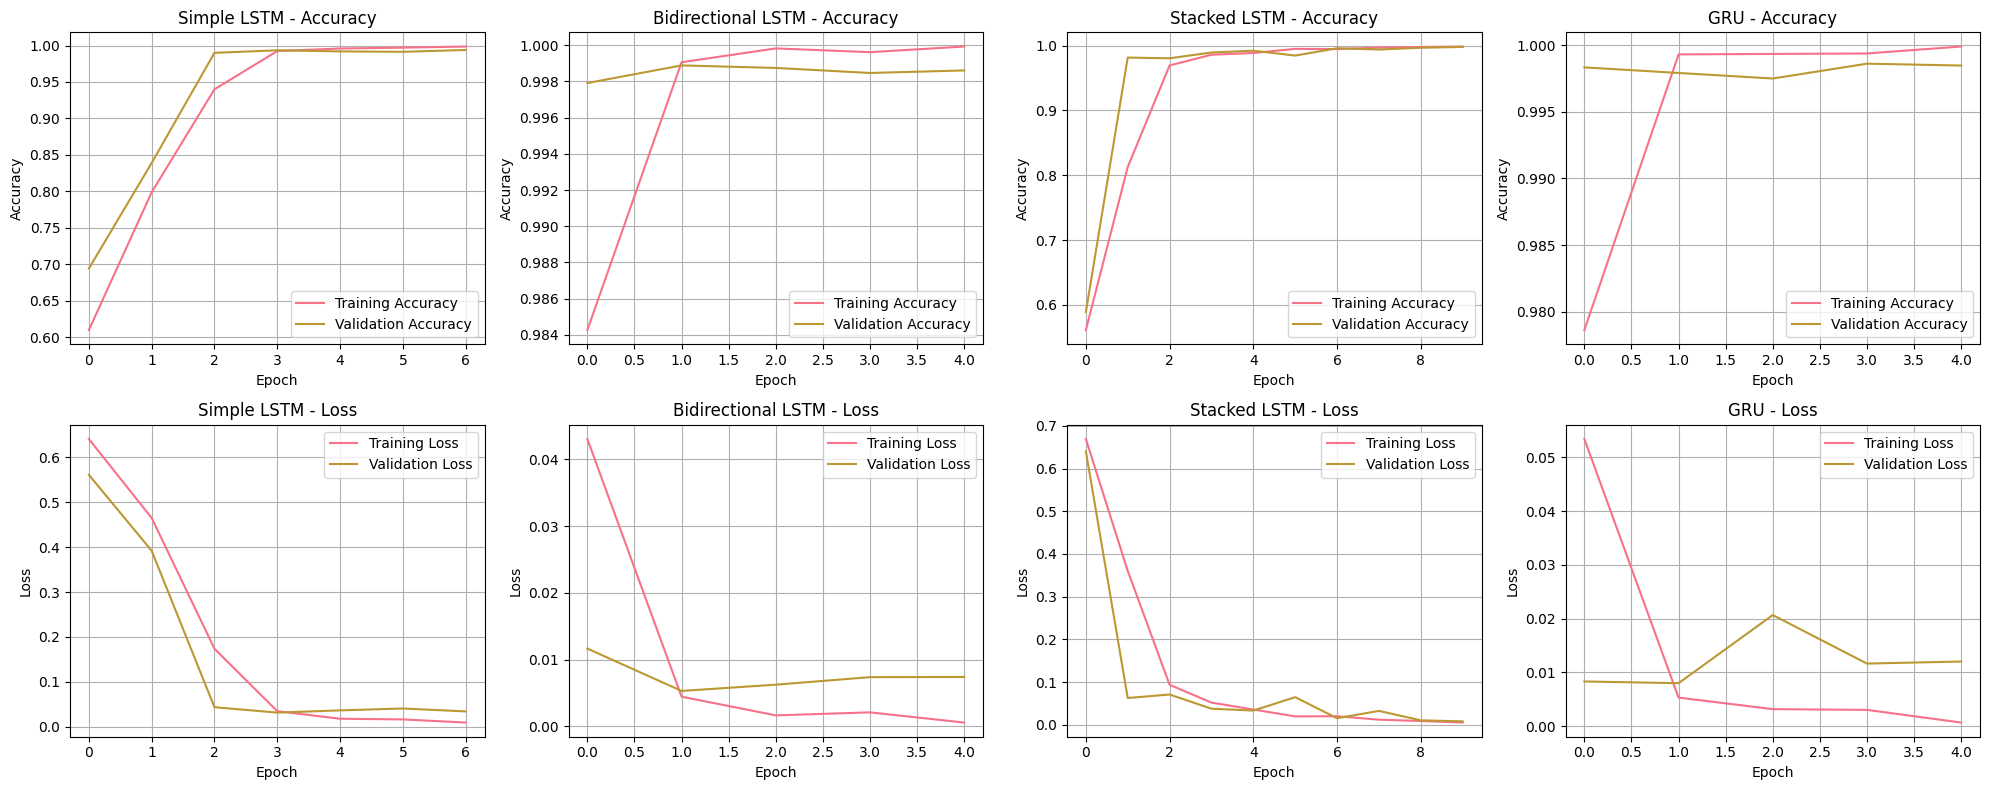

In [12]:
# Plot training histories for all models
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.flatten()

for idx, (name, history) in enumerate(histories.items()):
    # Accuracy plot
    ax1 = axes[idx]
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{name} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Loss plot
    ax2 = axes[idx + 4]
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{name} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

plt.tight_layout()
plt.show()

## Model Comparison

Model Performance Comparison:
             Model  Test_Accuracy  Test_Loss
Bidirectional LSTM       0.999220   0.004676
               GRU       0.998663   0.005436
      Stacked LSTM       0.997772   0.010907
       Simple LSTM       0.992537   0.032470


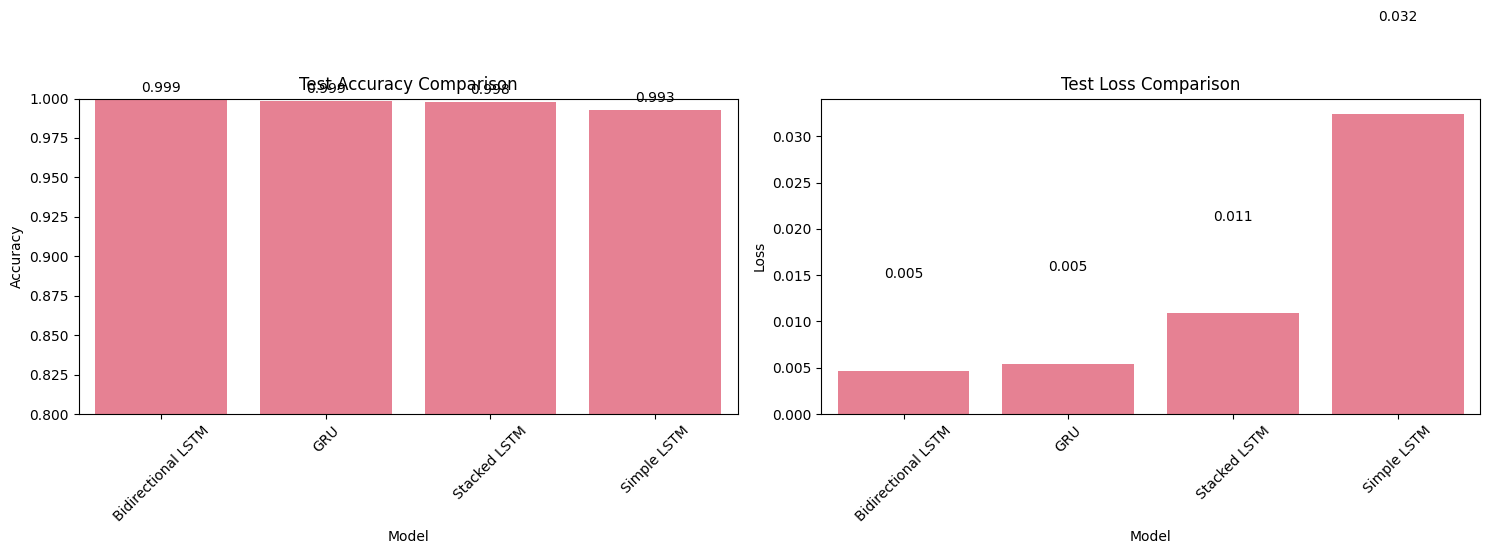

In [13]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test_Accuracy': [results[model]['accuracy'] for model in results.keys()],
    'Test_Loss': [results[model]['loss'] for model in results.keys()]
})

comparison_df = comparison_df.sort_values('Test_Accuracy', ascending=False)

print("Model Performance Comparison:")
print(comparison_df.to_string(index=False))

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy comparison
sns.barplot(data=comparison_df, x='Model', y='Test_Accuracy', ax=ax1)
ax1.set_title('Test Accuracy Comparison')
ax1.set_ylabel('Accuracy')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylim(0.8, 1.0)

for i, v in enumerate(comparison_df['Test_Accuracy']):
    ax1.text(i, v + 0.005, f'{v:.3f}', ha='center')

# Loss comparison
sns.barplot(data=comparison_df, x='Model', y='Test_Loss', ax=ax2)
ax2.set_title('Test Loss Comparison')
ax2.set_ylabel('Loss')
ax2.tick_params(axis='x', rotation=45)

for i, v in enumerate(comparison_df['Test_Loss']):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

## Detailed Evaluation of Best Model

Best performing model: Bidirectional LSTM
Test Accuracy: 0.9992

Classification Report for Bidirectional LSTM:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4695
        True       1.00      1.00      1.00      4283

    accuracy                           1.00      8978
   macro avg       1.00      1.00      1.00      8978
weighted avg       1.00      1.00      1.00      8978



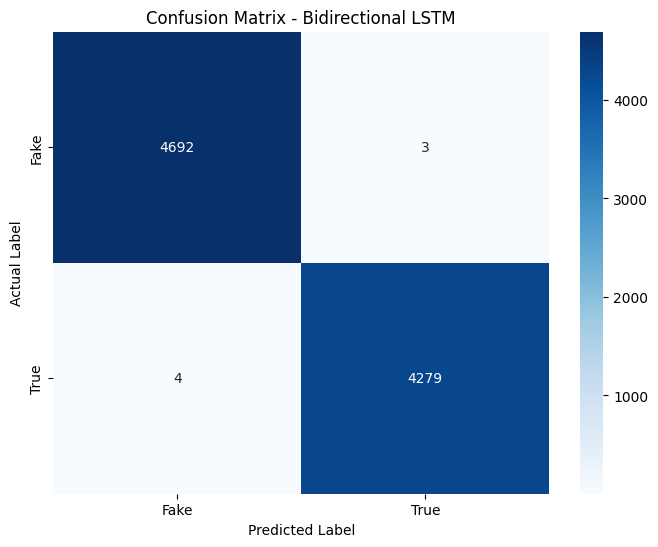


Detailed Metrics:
Precision: 0.9993
Recall: 0.9991
F1 Score: 0.9992
True Positives: 4279, False Positives: 3
True Negatives: 4692, False Negatives: 4


In [14]:
# Find the best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f"Best performing model: {best_model_name}")
print(f"Test Accuracy: {comparison_df.iloc[0]['Test_Accuracy']:.4f}")

# Generate predictions
y_pred_proba = best_model.predict(X_test, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Classification report
print(f"\nClassification Report for {best_model_name}:")
print(classification_report(y_test, y_pred, target_names=['Fake', 'True']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Additional metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"\nDetailed Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"True Positives: {tp}, False Positives: {fp}")
print(f"True Negatives: {tn}, False Negatives: {fn}")

## Prediction Confidence Analysis

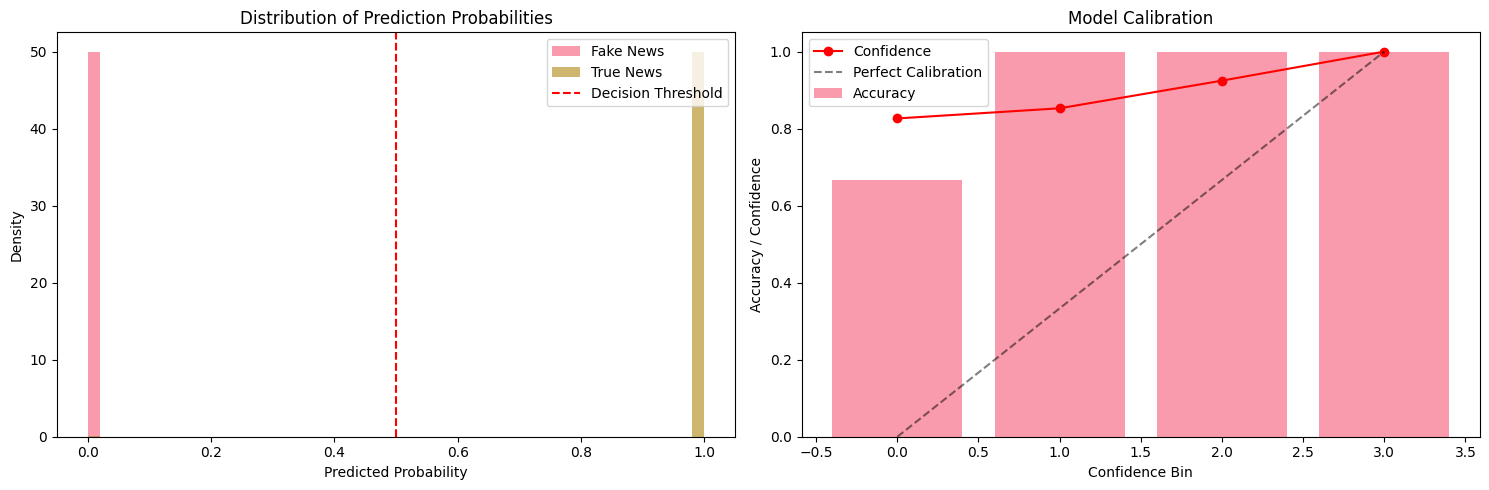


Calibration Analysis:
Bin 1: Confidence=0.826, Accuracy=0.667, Count=3
Bin 2: Confidence=0.853, Accuracy=1.000, Count=1
Bin 3: Confidence=0.925, Accuracy=1.000, Count=4
Bin 4: Confidence=1.000, Accuracy=0.999, Count=8970


In [15]:
# Analyze prediction confidence
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of prediction probabilities
ax1.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.7, label='Fake News', density=True)
ax1.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.7, label='True News', density=True)
ax1.axvline(x=0.5, color='red', linestyle='--', label='Decision Threshold')
ax1.set_xlabel('Predicted Probability')
ax1.set_ylabel('Density')
ax1.set_title('Distribution of Prediction Probabilities')
ax1.legend()

# Confidence vs accuracy
confidence = np.maximum(y_pred_proba.flatten(), 1 - y_pred_proba.flatten())
correct = (y_pred == y_test).astype(int)

# Bin by confidence and calculate accuracy
n_bins = 10
bin_boundaries = np.linspace(0.5, 1.0, n_bins + 1)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]

accuracies = []
confidences = []
counts = []

for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
    in_bin = (confidence > bin_lower) & (confidence <= bin_upper)
    if in_bin.sum() > 0:
        accuracy_in_bin = correct[in_bin].mean()
        avg_confidence_in_bin = confidence[in_bin].mean()
        count_in_bin = in_bin.sum()
        
        accuracies.append(accuracy_in_bin)
        confidences.append(avg_confidence_in_bin)
        counts.append(count_in_bin)

ax2.bar(range(len(accuracies)), accuracies, alpha=0.7, label='Accuracy')
ax2.plot(range(len(confidences)), confidences, 'ro-', label='Confidence')
ax2.plot([0, len(accuracies)-1], [0, 1], 'k--', alpha=0.5, label='Perfect Calibration')
ax2.set_xlabel('Confidence Bin')
ax2.set_ylabel('Accuracy / Confidence')
ax2.set_title('Model Calibration')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\nCalibration Analysis:")
for i, (acc, conf, count) in enumerate(zip(accuracies, confidences, counts)):
    print(f"Bin {i+1}: Confidence={conf:.3f}, Accuracy={acc:.3f}, Count={count}")

## Sample Predictions

In [16]:
# Function to make predictions on new text
def predict_with_lstm(model, tokenizer, text, max_length=MAX_SEQUENCE_LENGTH):
    """Predict if a text is fake news using LSTM model"""
    # Preprocess the text
    processed_text = light_preprocess(text)
    
    # Convert to sequence
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')
    
    # Make prediction
    prediction_prob = model.predict(padded_sequence, verbose=0)[0][0]
    prediction = "True News" if prediction_prob > 0.5 else "Fake News"
    
    return prediction, prediction_prob

# Test on some examples
test_indices = np.random.choice(len(X_test), 5, replace=False)

print(f"Sample Predictions using {best_model_name}:")
print("=" * 80)

for i, idx in enumerate(test_indices):
    # Get original text (this is a simplified approach)
    original_text = df.iloc[idx]['title'] + ' ' + df.iloc[idx]['text'][:300]
    true_label = "True News" if y_test[idx] == 1 else "Fake News"
    
    # Make prediction
    prediction, prob = predict_with_lstm(best_model, tokenizer, original_text)
    
    print(f"\nExample {i+1}:")
    print(f"Text: {original_text[:250]}...")
    print(f"True Label: {true_label}")
    print(f"Predicted: {prediction} (Confidence: {prob:.3f})")
    status = "✓" if prediction == true_label else "✗"
    print(f"Correct: {status}")
    print("-" * 80)

Sample Predictions using Bidirectional LSTM:

Example 1:
Text: HASTA LA VISTA Arnold! Guy Whose Affair With Housekeeper Produced Son, Destroyed 25 Yr. Marriage Says Trump Has Too Much “Baggage”…. Quits Celebrity Apprentice Arnold Schwarzenegger, who replaced Donald Trump as host of  Celebrity Apprentice,  is cal...
True Label: True News
Predicted: Fake News (Confidence: 0.000)
Correct: ✗
--------------------------------------------------------------------------------

Example 2:
Text: Macron's ideas can bolster Franco-German axis: Merkel TALLINN (Reuters) - German Chancellor Angela Merkel praised the ideas of French President Emmanuel Macron for reform of the European Union on Thursday and said they could form the basis for intens...
True Label: Fake News
Predicted: True News (Confidence: 1.000)
Correct: ✗
--------------------------------------------------------------------------------

Example 3:
Text:  WATCH: Jorge Ramos Makes Sean Hannity Look Like A Complete A**hole Univision ancho

# Save LSTM models and results for next notebooks
import os
os.makedirs('../models', exist_ok=True)
os.makedirs('../data/persistence', exist_ok=True)
os.makedirs('../results', exist_ok=True)

# Save the best model
best_model.save(f'../models/lstm_best_model.h5')

# Save all models
for name, model in models.items():
    safe_name = name.lower().replace(' ', '_')
    model.save(f'../models/lstm_{safe_name}.h5')

# Save the results
results_df = pd.DataFrame([
    {'model': name, 'accuracy': results[name]['accuracy'], 'loss': results[name]['loss']} 
    for name in results.keys()
])
results_df.to_csv('../results/lstm_model_comparison.csv', index=False)

print(f"\nBest model ({best_model_name}) saved as: ../models/lstm_best_model.h5")
print("All models and results saved successfully!")

# SAVE DATA FOR NEXT NOTEBOOKS
print("\n💾 SAVING DATA FOR NEXT NOTEBOOKS...")

# Combine CNN and LSTM results
all_model_results = {}

# Add CNN results if available
if 'cnn_data' in locals() and cnn_data:
    all_model_results['Standard CNN'] = {
        'accuracy': cnn_data.get('standard_cnn_accuracy', 0),
        'loss': cnn_data.get('standard_cnn_loss', 0),
        'model_type': 'CNN'
    }
    all_model_results['Multi-filter CNN'] = {
        'accuracy': cnn_data.get('multi_cnn_accuracy', 0),
        'loss': cnn_data.get('multi_cnn_loss', 0),
        'model_type': 'CNN'
    }

# Add LSTM results
for name in results.keys():
    all_model_results[name] = {
        'accuracy': results[name]['accuracy'],
        'loss': results[name]['loss'],
        'model_type': 'RNN/LSTM'
    }

# Save LSTM results and cumulative comparison
lstm_results = {
    'models': models,
    'results': results,
    'histories': histories,
    'best_model_name': best_model_name,
    'best_model_accuracy': comparison_df.iloc[0]['Test_Accuracy'],
    'comparison_df': comparison_df,
    'tokenizer': tokenizer,
    'config': {
        'max_vocab_size': MAX_VOCAB_SIZE,
        'max_sequence_length': MAX_SEQUENCE_LENGTH,
        'embedding_dim': EMBEDDING_DIM
    },
    'all_model_results': all_model_results
}

# Save as pickle for next notebooks
with open('../data/persistence/notebook4_lstm_results.pkl', 'wb') as f:
    pickle.dump(lstm_results, f)

# Save comparison data as CSV
comparison_df.to_csv('../data/persistence/notebook4_comparison.csv', index=False)

# Create cumulative comparison across all notebooks
cumulative_df = pd.DataFrame([
    {'Model': name, 'Accuracy': data['accuracy'], 'Loss': data['loss'], 'Type': data['model_type']}
    for name, data in all_model_results.items()
])
cumulative_df = cumulative_df.sort_values('Accuracy', ascending=False)
cumulative_df.to_csv('../data/persistence/cumulative_model_comparison.csv', index=False)

print("✅ LSTM results saved for Notebook 5 (Transformer)")
print("📁 Files saved:")
print("   - notebook4_lstm_results.pkl")
print("   - notebook4_comparison.csv") 
print("   - cumulative_model_comparison.csv")
print("   - LSTM models in ../models/")
print("🔗 Next notebook can load these with:")
print("   with open('../data/persistence/notebook4_lstm_results.pkl', 'rb') as f:")
print("       lstm_data = pickle.load(f)")
print("📊 Cumulative results available for all model types!")

In [18]:
# Save the best model
best_model.save(f'../models/lstm_best_model.h5')

# Save all models
for name, model in models.items():
    safe_name = name.lower().replace(' ', '_')
    model.save(f'../models/lstm_{safe_name}.h5')

# Save the results
results_df = pd.DataFrame([
    {'model': name, 'accuracy': results[name]['accuracy'], 'loss': results[name]['loss']} 
    for name in results.keys()
])
results_df.to_csv('../models/lstm_model_comparison.csv', index=False)

print(f"\nBest model ({best_model_name}) saved as: ../models/lstm_best_model.h5")
print("All models and results saved successfully!")


Best model (Bidirectional LSTM) saved as: ../models/lstm_best_model.h5
All models and results saved successfully!


## Training Time Analysis

Model Complexity vs Performance:
             Model  Parameters_M  Test_Accuracy  Test_Loss
Bidirectional LSTM      2.170901       0.999220   0.004676
               GRU      2.131301       0.998663   0.005436
      Stacked LSTM      2.166301       0.997772   0.010907
       Simple LSTM      2.085501       0.992537   0.032470


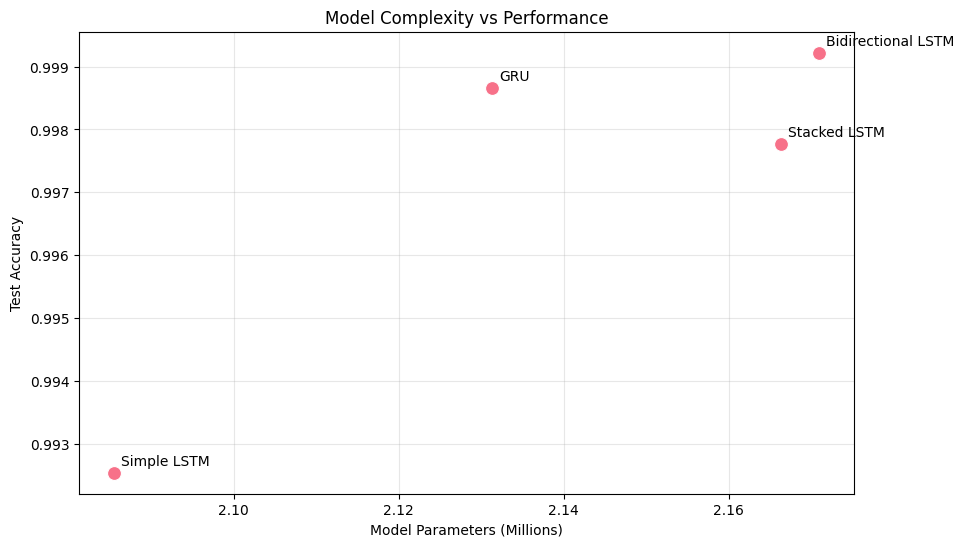

In [19]:
# Create a summary table with model complexity
model_params = {}
for name, model in models.items():
    model_params[name] = model.count_params()

summary_df = pd.DataFrame({
    'Model': list(model_params.keys()),
    'Parameters': list(model_params.values()),
    'Test_Accuracy': [results[name]['accuracy'] for name in model_params.keys()],
    'Test_Loss': [results[name]['loss'] for name in model_params.keys()]
})

summary_df = summary_df.sort_values('Test_Accuracy', ascending=False)
summary_df['Parameters_M'] = summary_df['Parameters'] / 1e6

print("Model Complexity vs Performance:")
print(summary_df[['Model', 'Parameters_M', 'Test_Accuracy', 'Test_Loss']].to_string(index=False))

# Plot parameters vs accuracy
plt.figure(figsize=(10, 6))
sns.scatterplot(data=summary_df, x='Parameters_M', y='Test_Accuracy', s=100)

for i, row in summary_df.iterrows():
    plt.annotate(row['Model'], (row['Parameters_M'], row['Test_Accuracy']), 
                xytext=(5, 5), textcoords='offset points')

plt.xlabel('Model Parameters (Millions)')
plt.ylabel('Test Accuracy')
plt.title('Model Complexity vs Performance')
plt.grid(True, alpha=0.3)
plt.show()

## Summary

### RNN/LSTM Model Results:
- **Simple LSTM**: Basic LSTM architecture
- **Bidirectional LSTM**: Processes sequences in both directions
- **Stacked LSTM**: Multiple LSTM layers for deeper feature extraction
- **GRU**: Faster alternative to LSTM with similar performance

### Key Findings:
1. LSTM models can capture sequential patterns and long-range dependencies in text
2. Bidirectional processing often improves performance by considering future context
3. Stacked architectures may provide deeper understanding but risk overfitting
4. GRU models are faster to train while maintaining competitive performance
5. Proper regularization (dropout, early stopping) is crucial for RNNs

### Advantages of LSTM approach:
- Excellent at capturing sequential dependencies
- Can handle variable-length inputs naturally
- Bidirectional processing captures full context
- Good performance on text classification tasks

### Disadvantages:
- Slower training compared to CNNs
- Sequential processing prevents parallelization
- Prone to overfitting on smaller datasets
- Memory intensive for long sequences

### Next Steps:
1. Experiment with attention mechanisms
2. Try pre-trained embeddings (Word2Vec, GloVe, FastText)
3. Implement transformer-based models (BERT, RoBERTa)
4. Ensemble multiple models for improved performance
5. Fine-tune hyperparameters and architecture details